In [ ]:
import pandas as pd
import numpy as np
import sklearn
import concurrent.futures
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import pickle as pkl
import h5py
import time
import gc

In [ ]:
RANDOM_STATE = 42

In [7]:
with concurrent.futures.ThreadPoolExecutor() as executor:
    f1 = executor.submit(pd.read_csv, './Data/DATETIMEEVENTS.csv')
    f2 = executor.submit(pd.read_csv, './Data/ICUSTAYS.csv')
    f3 = executor.submit(pd.read_csv, './Data/INPUTEVENTS_CV.csv')
    f4 = executor.submit(pd.read_csv, './Data/INPUTEVENTS_MV.csv')
    f5 = executor.submit(pd.read_csv, './Data/LABEVENTS.csv')
    f6 = executor.submit(pd.read_csv, './Data/PROCEDUREEVENTS_MV.csv')
    f7 = executor.submit(pd.read_csv, './Data/SERVICES.csv')
    f8 = executor.submit(pd.read_csv, './Data/ADMISSIONS.csv')
    #f9 = executor.submit(pd.read_csv, './Data/CHARTEVENTS.csv')
    f10 = executor.submit(pd.read_csv, './Data/D_ITEMS.csv')
    f11 = executor.submit(pd.read_csv, './Data/PATIENTS.csv')
    f12 = executor.submit(pd.read_csv, './Data/D_LABITEMS.csv')

    date_time_events = f1.result()
    icu_stays = f2.result()
    input_events_cv = f3.result()
    input_events_mv = f4.result()
    lab_events = f5.result()
    procedure_events = f6.result()
    services = f7.result()
    admissions = f8.result()
    d_items = f10.result()
    patients = f11.result()
    d_labitems = f12.result()

C:\Users\Greg\anaconda3\envs\mlenv\lib\threading.py:926: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  self.run()
C:\Users\Greg\anaconda3\envs\mlenv\lib\threading.py:926: DtypeWarning: Columns (7,9,17,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  self.run()


# Creating Care Events

In [4]:
events = pd.concat([input_events_cv[['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'CHARTTIME', 'ITEMID']].rename(columns={'CHARTTIME':'TIME'}), 
                    input_events_mv[['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'STARTTIME', 'ITEMID']].rename(columns={'STARTTIME':'TIME'}),
                    lab_events[['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'CHARTTIME', 'ITEMID']].rename(columns={'CHARTTIME':'TIME', 'ITEMID':'LAB_ITEMID'}),
                    date_time_events[['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'CHARTTIME', 'ITEMID']].rename(columns={'CHARTTIME':'TIME'}),
                    procedure_events[['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'STARTTIME', 'ITEMID']].rename(columns={'STARTTIME':'TIME'})
                   ])

# Remove events with no HADM_ID
events = events[events.HADM_ID.notna()]

# Convert HADM_ID to int
events.HADM_ID = events.HADM_ID.astype('int')

# Convert events.TIME to datetime
events.TIME = events.TIME.astype(np.datetime64)

events = events.sort_values(by=['HADM_ID', 'TIME']).reset_index(drop=True)

# Remove all duplicate times from each admission
events_no_dups = events.copy().drop_duplicates()

del input_events_cv
del input_events_mv
del lab_events
del date_time_events
del procedure_events

gc.collect()

### Convert events into encounters using code from https://github.com/EpistasisLab/MIMIC_trajectories/blob/master/Timing.ipynb.

In [146]:
unique_adms = events_no_dups.HADM_ID.unique()
FMT = '%Y-%m-%d %H:%M:%S'
delta_limit = timedelta(hours=0, minutes=59)

eid=1
encounters = []
for i in range(len(unique_adms)):
    id = unique_adms[i]
    
    if i % 1000 == 0:
        print(i)
    
    adm_events = events_no_dups[events_no_dups['HADM_ID'] == id]['TIME']
    
    last_e = None
    first_e = None
    for e in adm_events:
        if not first_e:
            first_e = e
        
        if last_e:
            tdelta = e - last_e
            if tdelta > delta_limit:
                encounters.append((eid, id, first_e, last_e))
                eid += 1
                first_e = None
                last_e = None
        last_e = e
print(len(encounters))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
4020925


In [147]:
encounters_df = pd.DataFrame(encounters, columns=['EID', 'HADM_ID', 'START_TIME', 'END_TIME'])
encounters_array = np.array(encounters_df)

# Convert start_time and end_time to datetime
encounters_array[:,2:] = encounters_array[:,2:].astype(np.datetime64)

In [148]:
#Ensure that start_event happend before end event
for encounter in encounters_array:
    if encounter[2] > encounter[3]:
        temp = encounter[2]
        encounter[2] = encounter[3]
        encounter[3] = temp

In [149]:
encounters_df = pd.DataFrame(encounters_array, columns=['EID', 'HADM_ID', 'START_TIME', 'END_TIME'])
encounters_df[['EID', 'HADM_ID']] = encounters_df[['EID', 'HADM_ID']].astype('int')
encounters_df[['START_TIME', 'END_TIME']] = encounters_df[['START_TIME', 'END_TIME']].astype(np.datetime64)
encounters_df.to_csv('./Data/Processed/All_Data/encounters_table_full.csv', index=False)

# Uncomment to read
"""encounters_df = pd.read_csv('./Data/Processed/All_Data/encounters_table_full.csv')
encounters_df[['EID', 'HADM_ID']] = encounters_df[['EID', 'HADM_ID']].astype('int')
encounters_df[['START_TIME', 'END_TIME']] = encounters_df[['START_TIME', 'END_TIME']].astype(np.datetime64)"""

In [7]:
# Drop rows in events that do not have encounter IDs in encounters_df
events = events[events.HADM_ID.isin(encounters_df.HADM_ID.unique())]

# Initialize encounter ID column in events dataframe
events['EID'] = np.nan

C:\Users\Greg\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [10]:
def get_encounter_id(admission):
    temp_enctrs = encounters_df[encounters_df.HADM_ID == admission.HADM_ID.unique()[0]].reset_index()
    temp_events = admission.reset_index()
    
    # Create an array of length equal to length of encounters. The value in each index of the array
    # corresponds to first index in the events dataframe where the encounter_id associated with the encounter 
    # should be located
    start_idx = np.searchsorted(temp_events.TIME, temp_enctrs.START_TIME, side='left')

    # Create an array of length equal to length of encounters. The value in each index of the array
    # corresponds to last index in the events dataframe where the encounter_id associated with the encounter 
    # should be located
    end_idx = np.searchsorted(temp_events.TIME, temp_enctrs.END_TIME, side='right') - 1
    
    # Loop through each encounter ID and assign it to the appropriate columns in temp_events
    for i in range(len(temp_enctrs)):
        temp_events.loc[start_idx[i]:end_idx[i], 'EID'] = temp_enctrs.EID[i]
    
    return temp_events

In [15]:
start = time.time()
events = events.groupby('HADM_ID').apply(get_encounter_id)
events = events.set_index('index')
print(time.time() - start)

1344.6273498535156


In [3]:
#events.to_csv('./Data/Processed/All_Data/events.csv', index=False) # uncomment to save to csv
events = pd.read_csv('./Data/Processed/All_Data/events.csv')

In [5]:
# Drop events with NaN Encounter ID
events = events[events.EID.notna()]

# Convert EID to integer
events['EID'] = events['EID'].astype('int')

C:\Users\Greg\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [14]:
# Merge care event with d_item to get item names
if 'LABEL' not in events.columns:
    events = pd.merge(events, d_items[['ITEMID', 'LABEL']], on='ITEMID', how='left')
    events = pd.merge(events, d_labitems[['ITEMID', 'LABEL']], left_on='LAB_ITEMID', right_on='ITEMID', how='left')
    events['LABEL'] = events['LABEL_x'].combine_first(events['LABEL_y'])
    events['ITEMID'] = events['ITEMID_x'].combine_first(events['ITEMID_y'])
    events = events.drop(columns=['LABEL_x', 'LABEL_y', 'ITEMID_x', 'ITEMID_y', 'LAB_ITEMID'])
    
# Merge with ADMISSIONS
if 'ADMITTIME' and 'INSURANCE' and 'ETHNICITY' not in events.columns:
    events = pd.merge(events, admissions[['HADM_ID', 'ADMITTIME', 'INSURANCE', 'ETHNICITY']], on='HADM_ID', how='left')
    
# Merge with PATIENTS
if 'GENDER' and 'DOB' and 'DOD' not in events.columns:
    events = pd.merge(events, patients[['SUBJECT_ID', 'GENDER', 'DOB', 'DOD']], on='SUBJECT_ID', how='left')
    
del d_items, d_labitems, admissions, patients
gc.collect()

17

In [15]:
# Splitting events since my computer does not have enough memory to perform one hot encoding on entire events dataframe 
split = np.array_split(events.SUBJECT_ID.unique(), 10)

e1 = events[events.SUBJECT_ID.isin(split[0])]
e2 = events[events.SUBJECT_ID.isin(split[1])]
e3 = events[events.SUBJECT_ID.isin(split[2])]
e4 = events[events.SUBJECT_ID.isin(split[3])]
e5 = events[events.SUBJECT_ID.isin(split[4])]
e6 = events[events.SUBJECT_ID.isin(split[5])]
e7 = events[events.SUBJECT_ID.isin(split[6])]
e8 = events[events.SUBJECT_ID.isin(split[7])]
e9 = events[events.SUBJECT_ID.isin(split[8])]
e10 = events[events.SUBJECT_ID.isin(split[9])]

'e2 = events[events.SUBJECT_ID.isin(split[1])]\ne3 = events[events.SUBJECT_ID.isin(split[2])]\ne4 = events[events.SUBJECT_ID.isin(split[3])]\ne5 = events[events.SUBJECT_ID.isin(split[4])]\ne6 = events[events.SUBJECT_ID.isin(split[5])]\ne7 = events[events.SUBJECT_ID.isin(split[6])]\ne8 = events[events.SUBJECT_ID.isin(split[7])]\ne9 = events[events.SUBJECT_ID.isin(split[8])]\ne10 = events[events.SUBJECT_ID.isin(split[9])]'

### Process encounter vectors per https://github.com/EpistasisLab/MIMIC_trajectories/blob/master/ProcessEncounterVectors.ipynb.

In [17]:
def encode_encounters(events):
    index_lists = [events.SUBJECT_ID.tolist(), events.HADM_ID.tolist(), events.EID.tolist()]

    tuples = list(zip(*index_lists))
    index = pd.MultiIndex.from_tuples(tuples, names=['SUBJECT_ID', 'HADM_ID', 'EID'])

    encounters = pd.DataFrame()
    
    # Find how long a patient survived after being admitted to the ICU
    encounters['SURVIVAL'] = (pd.to_datetime(events['DOD']).dt.date - pd.to_datetime(events['ADMITTIME']).dt.date).dt.days
    
    # Create label for whther patient survived more than 1 year after being admitted
    encounters['1YEAR'] = 0
    encounters.loc[(encounters['SURVIVAL'] > 0) & (encounters['SURVIVAL'] < 366), '1YEAR'] = 1
    
    # Drop survival column
    encounters = encoutners.drop('SURVIVAL', axis='columns')

    # Dates - ADMITTIME, DISCHTIME, DEATHTIME, DOB, DOD, DOD_HOSP, DOD_SSN
    events['ADMITTIME'] = pd.to_datetime(events['ADMITTIME']).dt.date
    events['DOB'] = pd.to_datetime(events['DOB']).dt.date
    encounters['AGE'] = events.apply(lambda e: (e['ADMITTIME'] - e['DOB']).days, axis=1)

    encounters = pd.concat([encounters,
                            pd.get_dummies(events['GENDER'])['M'],
                            pd.get_dummies(events['INSURANCE']),
                            pd.get_dummies(events['ETHNICITY']),
                            pd.get_dummies(events['LABEL'])
                           ],
                           axis=1)
    encounters.set_index(index, inplace=True)
    
    return encounters

In [21]:
# Get the first 10th of the encoutners table
encounters_1 = encode_encounters(e1)
encounters_1 = encounters_1.reset_index()

C:\Users\Greg\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\Greg\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
# Split encounters into chunks and save to file
with concurrent.futures.ThreadPoolExecutor() as executor:
    f1 = executor.submit(encode_encounters(e1))
    f2 = executor.submit(encode_encounters(e2))
    f3 = executor.submit(encode_encounters(e3))
    f4 = executor.submit(encode_encounters(e4))
    f5 = executor.submit(encode_encounters(e5))
    f6 = executor.submit(encode_encounters(e6))
    f7 = executor.submit(encode_encounters(e7))
    f8 = executor.submit(encode_encounters(e8))
    f9 = executor.submit(encode_encounters(e9))
    f10 = executor.submit(encode_encounters(e10))
    
    # Dealocate and garbage collect 
    del e1, e2, e3, e4, e5, e6, e7, e8, e9, e10
    gc.collect()
    
    encounters_1 = f1.result()
    encounters_2 = f2.result()
    encounters_3 = f3.result()
    encounters_4 = f4.result()
    encounters_5 = f5.result()
    encounters_6 = f6.result()
    encounters_7 = f7.result()
    encounters_8 = f8.result()
    encounters_9 = f9.result()
    encounters_10 = f10.result()

C:\Users\Greg\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\Greg\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


TypeError: 'DataFrame' object is not callable

In [6]:
encounters.to_csv('./Data/Processed/All_Data/encounters_1.csv', index=False)
#cols = list(pd.read_csv("./Data/Processed/All_Data/encounters_1b.csv", nrows=1))
#encounters = pd.read_csv('./Data/Processed/All_Data/encounters_1b.csv', engine='c', usecols =[i for i in cols if i != 'SURVIVAL'], dtype='int')

In [9]:
# Combine rows with duplicate encounter ids (EIDs) such that one row shows all events that happend in that encounter, 
# by grouping by HADM_ID and Encounter ID (EID) and seeing if any group in the row is true. If any value is true,
# then make the grouped value true. This should put a 1 under any event type that happend in the encounter
# timeframe 
#encounters_agg = e.groupby(['SUBJECT_ID','SURVIVAL', 'AGE', 'M', 'HADM_ID', 'EID'])[e.columns[6:]].any().astype('int')
encounters_agg = encounters.groupby(['SUBJECT_ID','1YEAR', 'AGE', 'M', 'HADM_ID', 'EID']).any().astype('int')

In [10]:
encounters_agg = encounters_agg.reset_index()

In [11]:
encounters_agg.to_csv('./Data/Processed/All_Data/encounters_agg.csv')

In [13]:
encounters_agg.to_hdf('./Data/Processed/All_Data/encounters_agg.h5', 'encounters')

In [274]:
encounters = pd.read_hdf('./Data/Processed/All_Data/encounters_agg.h5', 'encounters')

In [275]:
# Review the number of care events per admission
encounters.groupby('HADM_ID').size().describe()

count    7788.000000
mean       71.781587
std       127.334238
min         1.000000
25%        18.000000
50%        34.000000
75%        70.000000
max      2624.000000
dtype: float64

''

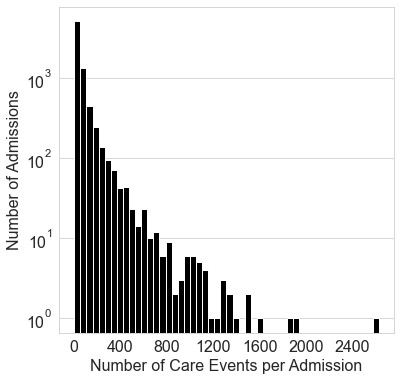

In [281]:
fig, ax = plt.subplots(figsize=(6,6))
plt.hist(encounters.groupby('HADM_ID').size(), bins=50, log=True, color='black')
plt.grid(axis='x')
plt.xticks(np.arange(0,2600,400),fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Number of Care Events per Admission', fontsize=16)
plt.ylabel('Number of Admissions', fontsize=16)
;